# this is to check effect of thermodynamic factors
other parameters are: (1) Dcross=1.5e-20; (2) conductivity Andrew; diffusivity Valoen; (3) c_EC_0=6250

In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
a=[1,2,3];b=[3,4,5]; c=[5,6,7];
d=[*a,*b,*c]
print(d)

[1, 2, 3, 3, 4, 5, 5, 6, 7]


In [3]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R11/'; 
Target  = 'CrateScan_TDF_Valoen_high_Dx/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [4]:
# Define 3 models: normal DFN, single transport by high Dec, double transport
Model_DFN  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "single no consume wo refill",
    "electrolyte conductivity": "full"  ,}) 
Model_SD  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "full"  ,}) 
Model_DD  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "sol full"  ,}) 
Model_All =[ Model_DFN,  Model_SD, Model_DD ]
Str_model =[ 'Model_DFN',  'Model_SD', 'Model_DD' ]
# 3 parameter set: Andrew, constant. Valoen
Para_All = []
for i in range(0,6):
    para=pybamm.ParameterValues("Li2023_ECdrag")
    para.update({"EC Lithium ion cross diffusivity [m2.s-1]":1.5e-10})
    para.update({"EC initial concentration in electrolyte [mol.m-3]":6250})
    para.update({"Cation transference number":t_0plus_constant})
    para.update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_Valoen2005Constant})
    para.update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_Valoen2005Constant})
    Para_All.append(para)
Para_All[0].update({"1 + dlnf/dlnc":electrolyte_TDF_EC_DMC_1_1_Landesfeind2019})
Para_All[0].update({"TDF of EC":1})
Para_All[1].update({"1 + dlnf/dlnc":electrolyte_TDF_EC_DMC_1_1_Landesfeind2019})
Para_All[1].update({"TDF of EC":5})
Para_All[2].update({"1 + dlnf/dlnc":electrolyte_TDF_EC_DMC_1_1_Landesfeind2019})
Para_All[2].update({"TDF of EC":15})
Para_All[3].update({"1 + dlnf/dlnc":15})
Para_All[3].update({"TDF of EC":1})
Para_All[4].update({"1 + dlnf/dlnc":15})
Para_All[4].update({"TDF of EC":5})
Para_All[5].update({"1 + dlnf/dlnc":15})
Para_All[5].update({"TDF of EC":15})
Str_para = ['Landesf-1', 'Landesf-5', 'Landesf-15', '15-1','15-5','15-15']

In [5]:
# all parameter: 6*3*6=108 cases
TDF_All_All = [];Rate_Dis_All = [0.5,2];  Rate_Cha_All = [1,] # ,4,6,8,10
for i in range(0,6):
    TDF_i_All = []; para = Para_All[i]; str_para = Str_para[i];
    for model,str_model in zip(Model_All,Str_model):
        TDF_i_All.append(
            Scan_Crate(Rate_Dis_All,Rate_Cha_All,model,para,str_model,str_para)
            )
    TDF_All_All.append(TDF_i_All)
    del TDF_i_All

In [6]:
import pickle
TDF_Valoen_HighDx = TDF_All_All
fileObj = open(BasicPath + Target + 'BigList.obj', 'wb')
pickle.dump(TDF_Valoen_HighDx,fileObj)
fileObj.close()

In [7]:
Exp_Crate = [0.2, 0.3, 0.4, 0.5, 1, 2, 3]; Exp_Cap = [ 4.815, 4.75, 4.82, 4.82, 4.64, 3.298, 1.983]; 


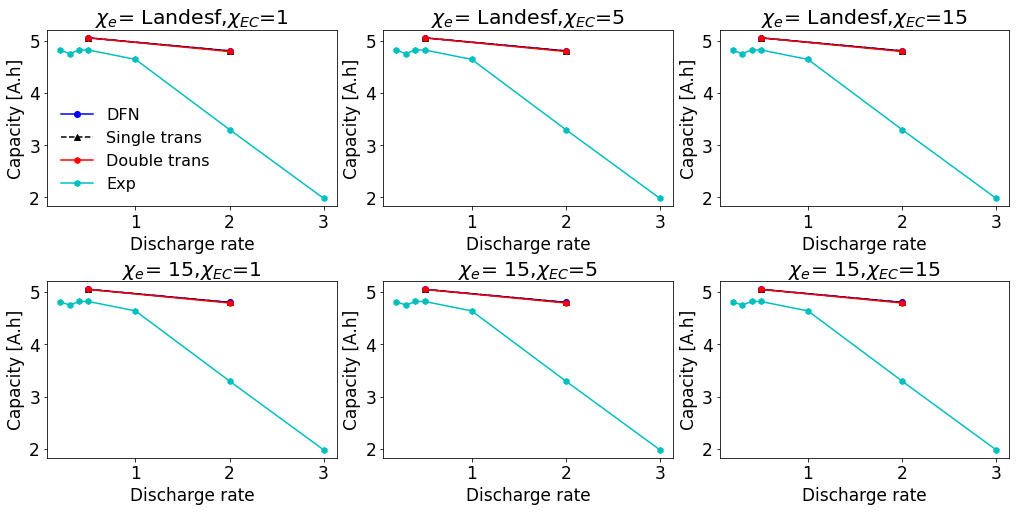

In [11]:
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
Str=[ 'DFN',  'Single trans', 'Double trans' ]
fig, axs = plt.subplots(2,3,figsize=(14, 7), layout='constrained')
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h']
for k in range(0,6):
    if k < 3:
        m=0; n =k
    else:
        m=1; n=k-3
    for i in range(0,3):
        axs[m,n].plot(Rate_Dis_All,TDF_All_All[k][i]['Cap_Dis_All'],color=Colors[i],linestyle=LS[i],marker = MS[i],label=Str[i])
        str_1 = Str_para[k][0:Str_para[k].find('-')]
        str_2 = Str_para[k][Str_para[k].find('-')+1:]
        axs[m,n].set_title(r'$\chi_e$'+f'= {str_1},' + r'$\chi_{EC}$' + f'={str_2}',loc='center')
    axs[m,n].plot(Exp_Crate,Exp_Cap,color='c',linestyle=LS[i],marker = MS[i],label='Exp')
    for m in range(0,2):
        for n in range(0,3):
            axs[m,n].set_xlabel("Discharge rate")
            axs[m,n].set_ylabel("Capacity [A.h]")
axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-1},loc='best',frameon=False,)
# plt.savefig(
#    BasicPath + Target+
#    "Fig. 1-1 fit to exp - Summary Crate.png", dpi=300) 

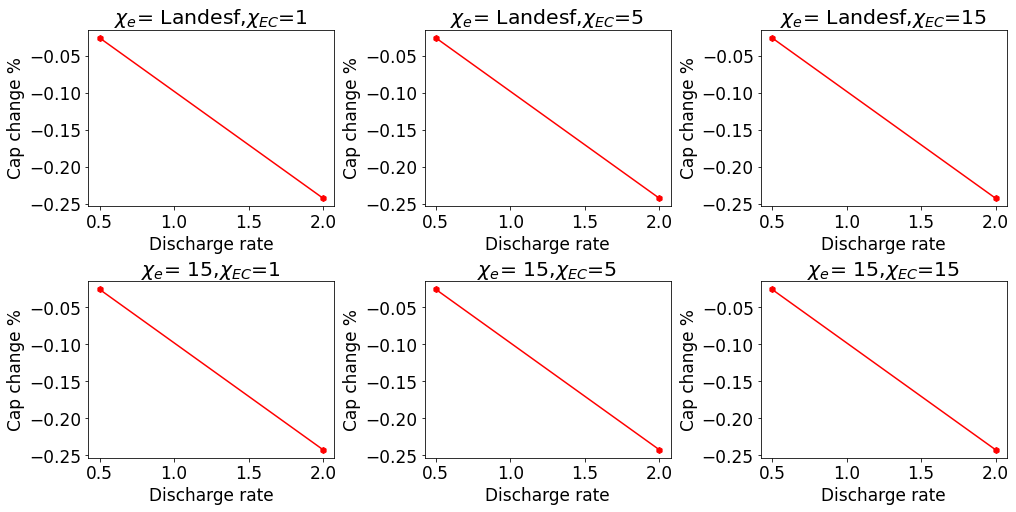

In [9]:
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
Str=[ 'DFN',  'Single trans', 'Double trans' ]
fig, axs = plt.subplots(2,3,figsize=(14, 7), layout='constrained')
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h']
for k in range(0,6):
    if k < 3:
        m=0; n =k
    else:
        m=1; n=k-3
    
    cap_DFN = TDF_All_All[k][0]['Cap_Dis_All'];   cap_double = TDF_All_All[k][-1]['Cap_Dis_All']; 
    y_temp = ((np.array(cap_double) - np.array(cap_DFN)) / np.array(cap_DFN) *100 ).tolist()
    axs[m,n].plot(Rate_Dis_All,y_temp,color=Colors[-1],linestyle=LS[-1],marker = MS[-1],label=Str[-1])
    str_1 = Str_para[k][0:Str_para[k].find('-')]
    str_2 = Str_para[k][Str_para[k].find('-')+1:]
    axs[m,n].set_title(r'$\chi_e$'+f'= {str_1},' + r'$\chi_{EC}$' + f'={str_2}',loc='center')
    for m in range(0,2):
        for n in range(0,3):
            axs[m,n].set_xlabel("Discharge rate")
            axs[m,n].set_ylabel("Cap change %")
#axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-1},loc='best',frameon=False,)
# plt.savefig(
#    BasicPath + Target+
#    "Fig. 2 - Dis Cap change % Crate.png", dpi=300) 

IndexError: list index out of range

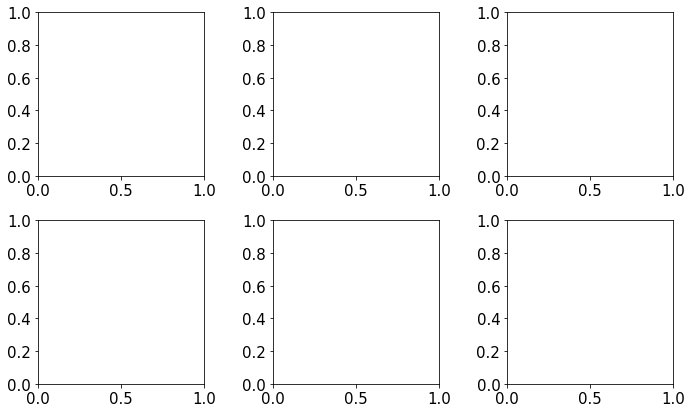

In [10]:
# single cases potential decomposition:
# Str_para = ['Landesf-1', 'Landesf-5', 'Landesf-15', '15-1','15-5','15-15']
# Rate_Dis_All = [0.5,2,4,6,8,10]
font = {'family' : 'DejaVu Sans','size'   : 15}
mpl.rc('font', **font)
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h'];Str=[ 'DFN',  'Single trans', 'Double trans' ]
for o in range(0,6):
    fig, axs = plt.subplots(2,3, figsize=(10,6),tight_layout=True)
    Keys_t_var = [
        "Battery voltage [V]",
        "X-averaged battery reaction overpotential [V]",
        "X-averaged battery concentration overpotential [V]",
        "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
        "X-averaged battery electrolyte ohmic losses [V]",
        "X-averaged battery solid phase ohmic losses [V]",
    ]
    Title_keys = [
        "Battery voltage",
        "Reaction overpotential",
        "c(Li+) overpotential",
        "c(EC) overpotential",
        "Elely ohmic losses",
        "Solid ohmic losses"
    ]
    for k in range(0,3):
        sol = TDF_All_All[o][k]['MyDict_All'][3]['Solution'] # Rate_Dis_All = [0.5,2,4,6,8,10]
        time_1 = sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0]
        for i in range(0,6): # 0 1 2 3 4 5 --> [0,0] [0,1], [0,2], [1,0], [1,1], [1,2]   
            var =  sol.cycles[0].steps[1][Keys_t_var[i]].entries
            if i < 3:
                m=0; n =i
            else:
                m=1; n=i-3
            axs[m,n].plot(time_1, var,color=Colors[k],linestyle=LS[k],label=Str[k]) # label="1st cycle"
            axs[m,n].set_title(Title_keys[i],fontdict={'family':'DejaVu Sans','size':fs-1})
            axs[m,n].set_ylabel("Potential [V]",   fontdict={'family':'DejaVu Sans','size':fs})
            axs[m,n].set_xlabel('Time [s]',   fontdict={'family':'DejaVu Sans','size':fs})
            axs[m,n].set_ylim(-1.2,0.5)
            
            labels = axs[m,n].get_xticklabels() + axs[m,n].get_yticklabels(); 
            [label.set_fontname('DejaVu Sans') for label in labels]
            axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-5},loc='best',frameon=False)  
        axs[0,0].set_ylim(2.49,4.2)
    # plt.savefig(BasicPath + Target+ Str_para[o]+" 6C dis - Single case vol decompos.png", dpi=300)

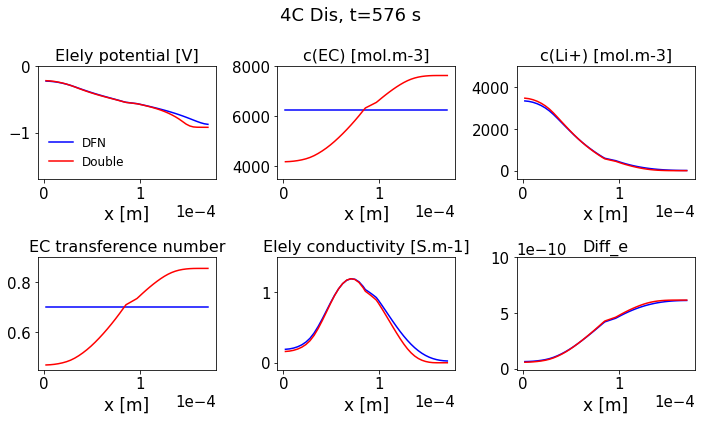

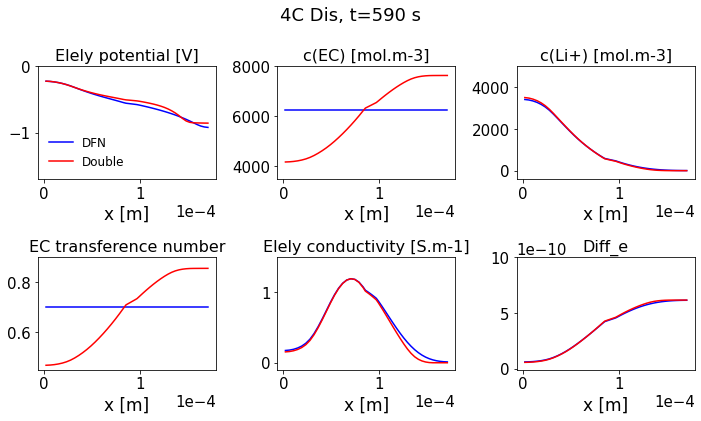

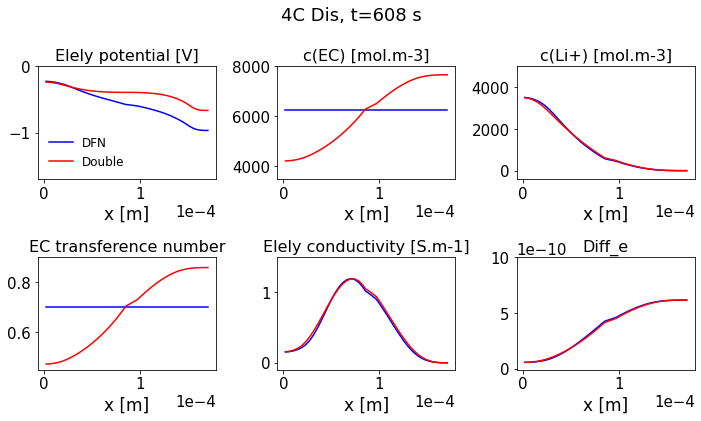

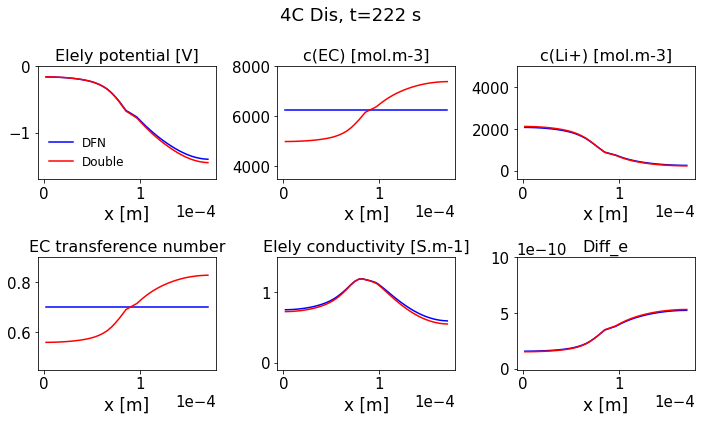

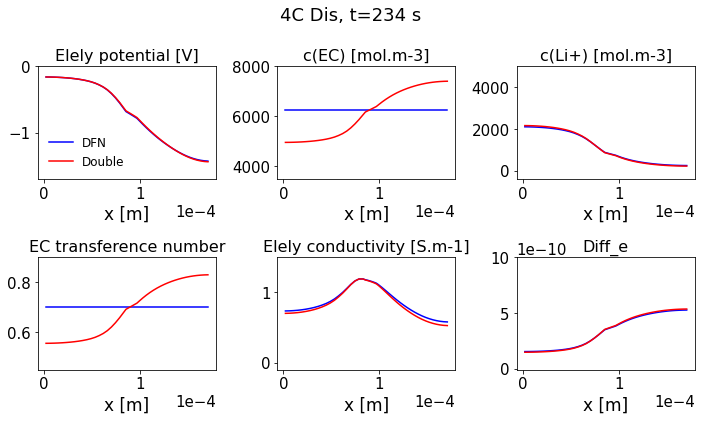

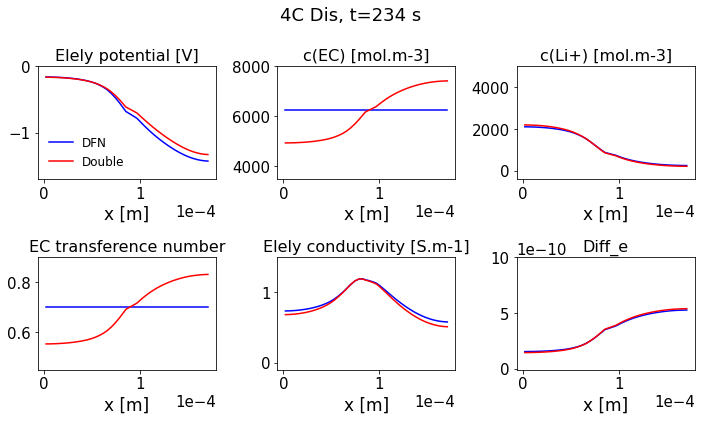

In [ ]:
# compare electrolyte properties: roughly end of 6C discharge, but make it fair
def FindClose(time_DD,t_select): # Input must be a list
    for i in range(0,len(time_DD)):
        if abs(time_DD[i] - t_select)<1e-3:
            break
    return i
font = {'family' : 'DejaVu Sans','size'   : 15}
mpl.rc('font', **font)
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
var_elely = [
    "Electrolyte potential [V]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "EC transference number",
    "Electrolyte conductivity [S.m-1]",
    "Electrolyte diffusivity [m2.s-1]",
]
Title_keys = [
    "Elely potential [V]",
    "c(EC) [mol.m-3]",
    "c(Li+) [mol.m-3]",
    "EC transference number",
    "Elely conductivity [S.m-1]",
    "Diff_e",
]
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h'];
Str=[ 'DFN',  'Single', 'Double' ]
for o in range(0,6):
    fig, axs = plt.subplots(2,3, figsize=(10,6),tight_layout=True)
    for i in range(0,6):
        # Plot only DFN and double, ignore single 
        Crate_index = 2  # Rate_Dis_All = [0.5,2,4,6,8,10]
        # select the same time:
        sol_DFN = TDF_All_All[o][0]['MyDict_All'][Crate_index]['Solution']
        time_DFN = (sol_DFN.cycles[0].steps[1]['Time [s]'].entries-sol_DFN.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()

        sol_DD = TDF_All_All[o][2]['MyDict_All'][Crate_index]['Solution'] 
        time_DD = (sol_DD.cycles[0].steps[1]['Time [s]'].entries-sol_DD.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()

        t_select = min(time_DFN[-2],time_DD[-2])
        i_DD = FindClose(time_DD,t_select)
        i_DF = FindClose(time_DFN,t_select)
        # print(f'Time selected is {time_DD[i_DF]} and {time_DFN[i_DD]} s')
        
        x_DFN =   sol_DFN.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_DFN =   sol_DFN.cycles[0].steps[1][var_elely[i]].entries[:,i_DF]
        x_DD  =   sol_DD.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_DD  =   sol_DD.cycles[0].steps[1][var_elely[i]].entries[:,i_DD]
        if i < 3:
            m=0; n =i
        else:
            m=1; n=i-3
        axs[m,n].plot(x_DFN, y_DFN,color=Colors[0],linestyle=LS[0],label=Str[0]) 
        axs[m,n].plot(x_DD,  y_DD, color=Colors[2],linestyle=LS[2],label=Str[2]) 
        axs[m,n].set_title(Title_keys[i],fontdict={'family':'DejaVu Sans','size':fs-1})
        axs[m,n].set_xlabel(x_loc[i],   fontdict={'family':'DejaVu Sans','size':fs})
        axs[m,n].ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-0.01,0.01], useOffset=None, 
            useLocale=None, useMathText=None)

        axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-5},loc='best',frameon=False)  
        axs[0,0].set_ylim(-1.7,0.0)
        axs[0,1].set_ylim(3500,8000)
        axs[0,2].set_ylim(-400,5000)
        axs[1,0].set_ylim(0.45,0.9)
        axs[1,1].set_ylim(-0.1,1.5)
        axs[1,2].set_ylim(-0.1e-10,1e-9)
    
    fig.suptitle(f"{Rate_Dis_All[Crate_index]}C Dis, t={round(t_select)} s", fontsize=fs+1)
    plt.savefig(
        BasicPath + Target+ Str_para[o]
        +f" end of {Rate_Dis_All[Crate_index]}C dis - electrolyte properties.png", 
        dpi=300) 

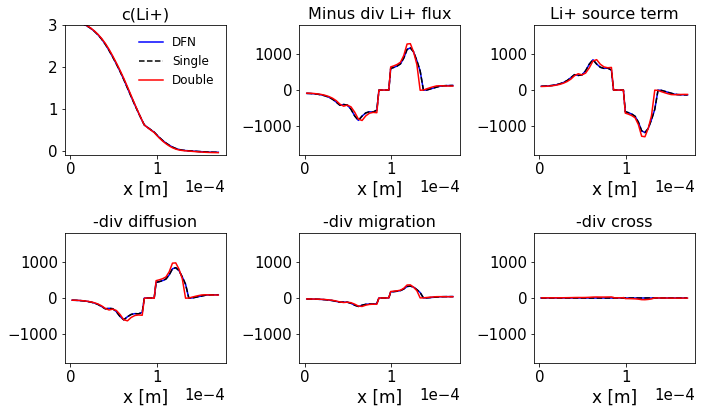

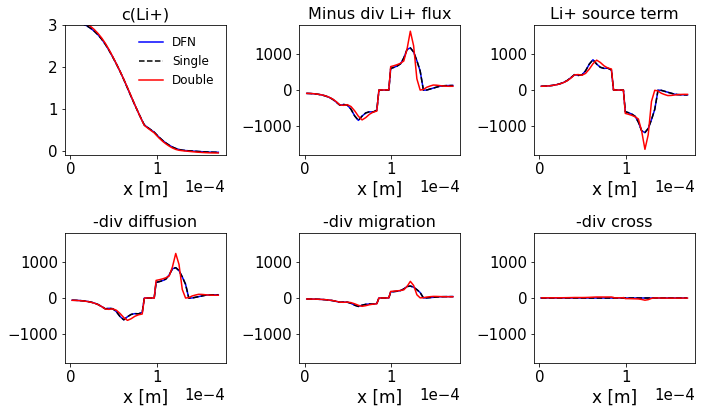

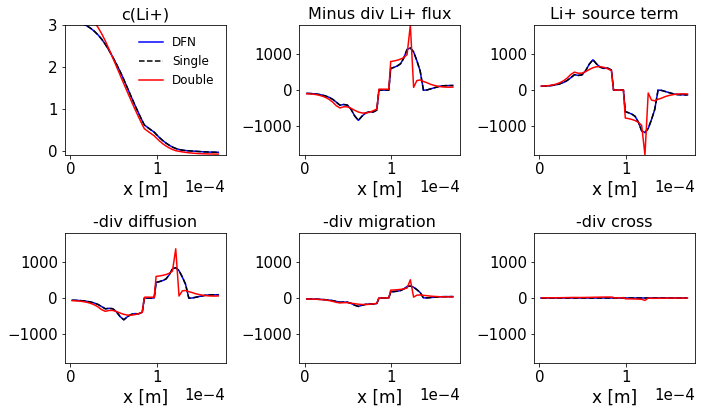

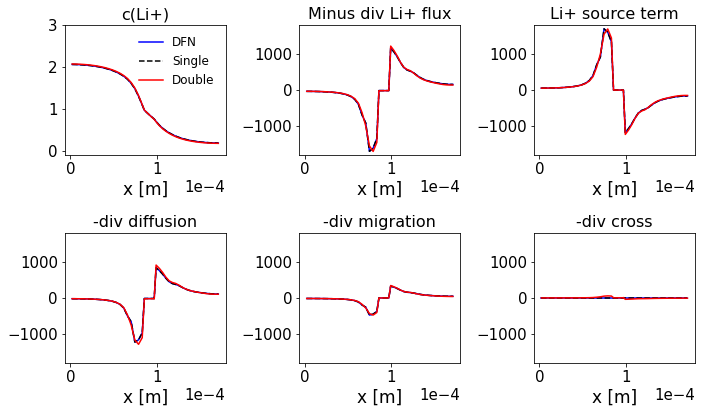

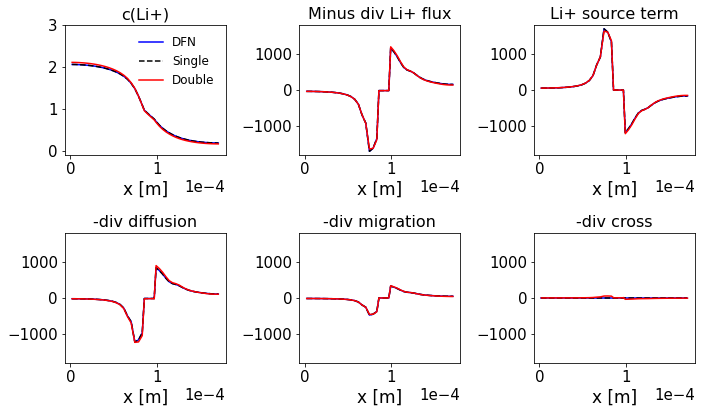

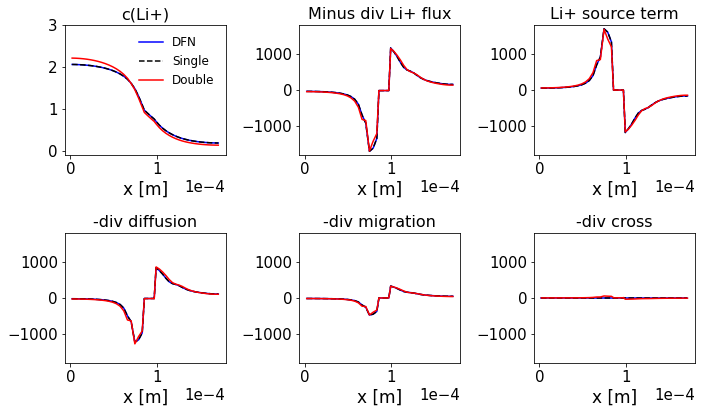

In [ ]:
# Li+ flux contribution:
# compare electrolyte properties: end of 4C discharge
font = {'family' : 'DejaVu Sans','size'   : 15}
mpl.rc('font', **font)
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
var_LiFlux = [
    "Electrolyte concentration",
    "Minus div Li+ flux",
    "Li+ source term",
    "Minus div Li+ flux by diffusion",
    "Minus div Li+ flux by migration",
    "Minus div Li+ flux by solvent",
]
Title_keys = [
    "c(Li+)",
    "Minus div Li+ flux",
    "Li+ source term",
    "-div diffusion",
    "-div migration",
    "-div cross",
]
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h'];
Str=[ 'DFN',  'Single', 'Double' ]
for o in range(0,6):
    fig, axs = plt.subplots(2,3, figsize=(10,6),tight_layout=True)
    for i in range(0,6):
        for k in range(0,3):
            sol = TDF_All_All[o][k]['MyDict_All'][3]['Solution']
            x =   sol.cycles[0].steps[1][x_loc[i]].entries[:,0]
            y =   sol.cycles[0].steps[1][var_LiFlux[i]].entries[:,-1]
            if i < 3:
                m=0; n =i
            else:
                m=1; n=i-3
            axs[m,n].plot(x, y,color=Colors[k],linestyle=LS[k],label=Str[k]) 
            axs[m,n].set_title(Title_keys[i],fontdict={'family':'DejaVu Sans','size':fs-1})
            axs[m,n].set_xlabel(x_loc[i],   fontdict={'family':'DejaVu Sans','size':fs})
            axs[m,n].ticklabel_format( 
                axis='x', style='sci',
                scilimits=[-0.01,0.01], useOffset=None, 
                useLocale=None, useMathText=None)
            axs[m,n].set_ylim(-1800,1800)
        axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-5},loc='best',frameon=False)  
        axs[0,0].set_ylim(-0.1,3)
    # plt.savefig(BasicPath + Target+ Str_para[o]+" end of 4C dis - Li flux decom.png", dpi=300)

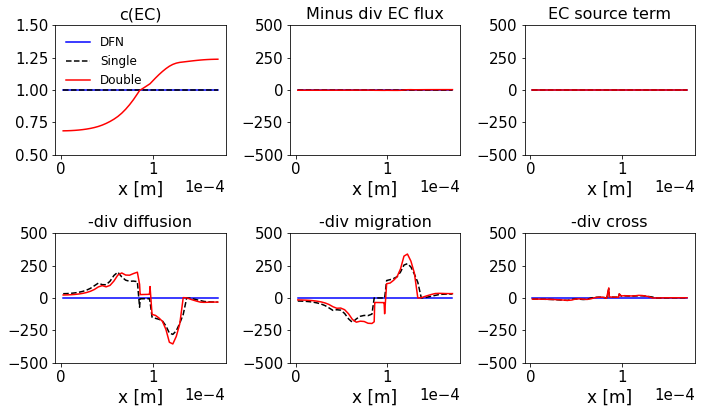

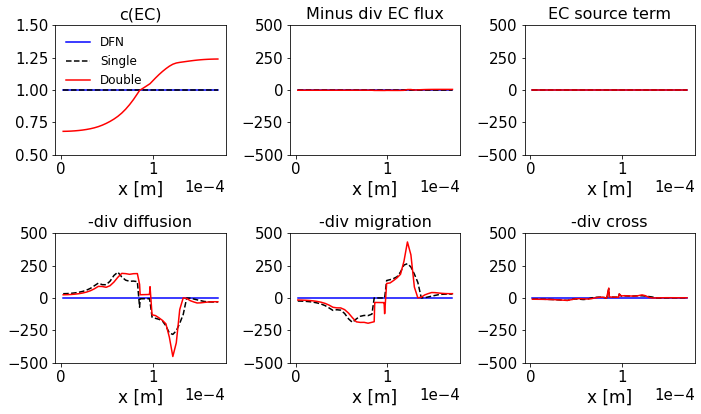

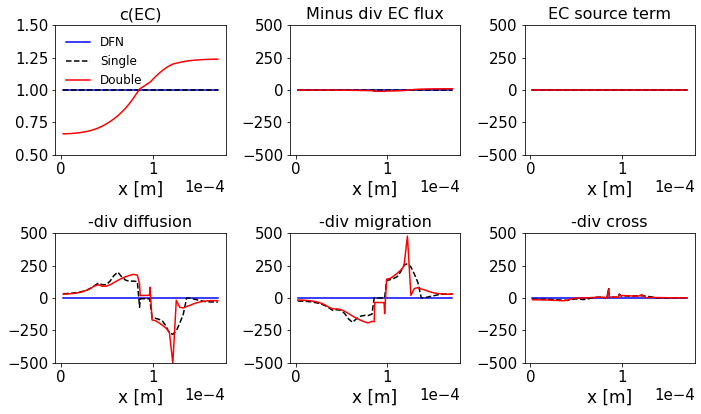

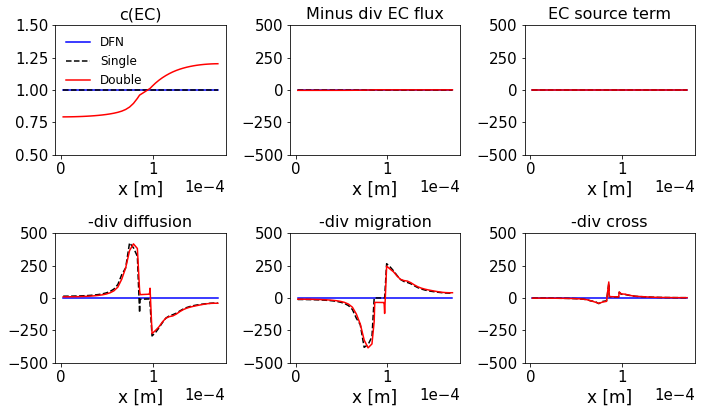

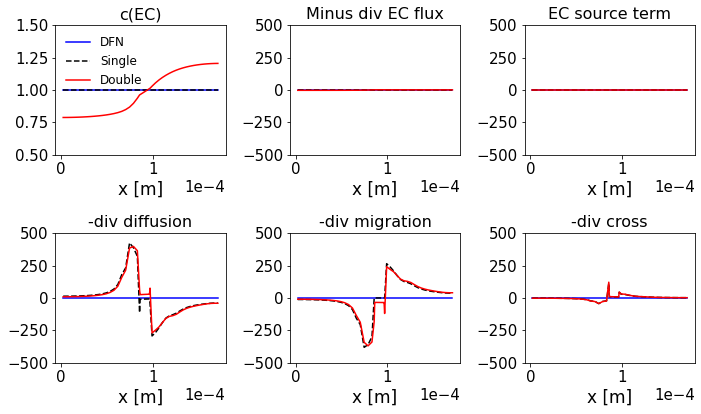

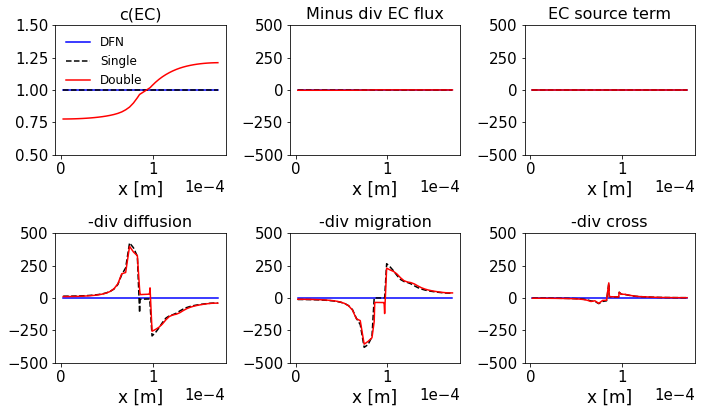

In [ ]:
# Li+ flux contribution:
# compare electrolyte properties: end of 4C discharge
font = {'family' : 'DejaVu Sans','size'   : 15}
mpl.rc('font', **font)
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
var_LiFlux = [
    "EC concentration",
    "Minus div EC flux",
    "EC source term (SEI)",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
]
Title_keys = [
    "c(EC)",
    "Minus div EC flux",
    "EC source term",
    "-div diffusion",
    "-div migration",
    "-div cross",
]
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h'];
Str=[ 'DFN',  'Single', 'Double' ]
for o in range(0,6):
    fig, axs = plt.subplots(2,3, figsize=(10,6),tight_layout=True)
    for i in range(0,6):
        for k in range(0,3):
            sol = TDF_All_All[o][k]['MyDict_All'][3]['Solution']
            x =   sol.cycles[0].steps[1][x_loc[i]].entries[:,0]
            y =   sol.cycles[0].steps[1][var_LiFlux[i]].entries[:,-1]
            if i < 3:
                m=0; n =i
            else:
                m=1; n=i-3
            X_Len = min(len(x),len(y))
            axs[m,n].plot(x[0:X_Len], y[0:X_Len],color=Colors[k],linestyle=LS[k],label=Str[k]) 
            axs[m,n].set_title(Title_keys[i],fontdict={'family':'DejaVu Sans','size':fs-1})
            axs[m,n].set_xlabel(x_loc[i],   fontdict={'family':'DejaVu Sans','size':fs})
            axs[m,n].ticklabel_format( 
                axis='x', style='sci',
                scilimits=[-0.01,0.01], useOffset=None, 
                useLocale=None, useMathText=None)
            axs[m,n].set_ylim(-500,500)
        axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-5},loc='best',frameon=False)  
        axs[0,0].set_ylim(0.5,1.5)
    # plt.savefig(BasicPath + Target+ Str_para[o]+" end of 4C dis - EC flux decom.png", dpi=300)